# Compositional modeling with C-sets and structured cospans

**Evan Patterson**  
[Topos Institute](https://topos.institute/)

**James Fairbanks**  
University of Florida

**Multiscale Modeling and Viral Pandemics Working Group**  
July 8, 2021

## Outline

Motivated by James' introduction, we will drill down into several technical topics:

1. **C-sets** for Petri nets and other relational data
2. **Structured cospans** for open systems
3. **Operadic** (hierarchical) composition of open systems

## C-sets for relational data

C-sets are a mathematical structure and a data structure for relational data  
([Spivak 2012](https://arxiv.org/abs/1009.1166), [Patterson, Lynch, Fairbanks 2021](https://arxiv.org/abs/2106.04703)):

- Think: a collection of interlinked tables
- Similar to relational databases, but an in-memory data structure
- Supports queries, gluing, and many other useful operations

### Example: Graphs

Graphs are a simple but fundamental example of C-sets.

The schema for (directed) graphs has:

- two tables: $V$ (vertices) and $E$ (edges)
- two links/foreign keys: $E \xrightarrow{\mathrm{src}} V$ (source vertex) and $E \xrightarrow{\mathrm{tgt}} V$ (target vertex)

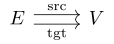

In [1]:
using TikzPictures

# XXX: Hack to increase size by scaling.
TikzPictures.write_adjustbox_options(tex::IO, tp::TikzPicture) =
    println(tex, "\\begin{adjustbox}{scale=$(tp.width)}")

TikzCD(tex::AbstractString) = TikzPicture(
    tex, width="2", height="2", environment="tikzcd",
    preamble=raw"\usepackage{tikz-cd}\usepackage{amsmath,amssymb}")

# https://q.uiver.app/?q=WzAsMixbMCwwLCJFIl0sWzEsMCwiViJdLFswLDEsIlxcbWF0aHJte3NyY30iLDAseyJvZmZzZXQiOi0xfV0sWzAsMSwiXFxtYXRocm17dGd0fSIsMix7Im9mZnNldCI6MX1dXQ==
TikzCD(raw"""
E & V
\arrow["{\mathrm{src}}", shift left=1, from=1-1, to=1-2]
\arrow["{\mathrm{tgt}}"', shift right=1, from=1-1, to=1-2]""")

Using our package [Catlab.jl](https://github.com/AlgebraicJulia/Catlab.jl), the schema is:

In [2]:
using Catlab, Catlab.CategoricalAlgebra

@present SchemaGraphs(FreeSchema) begin
    V::Ob
    E::Ob
    src::Hom(E,V)
    tgt::Hom(E,V)
end;

Create the corresponding datatype in one line of code:

```julia
const Graph = CSetType(SchemaGraphs, index=[:src,:tgt])
```

(We do not run this code because graphs are included with Catlab.)

As an example, here is the directed 4-cycle in tabular and graphical form:

In [3]:
using Catlab.Graphs

g = cycle_graph(Graph, 4)

E,src,tgt
1,1,2
2,2,3
3,3,4
4,4,1


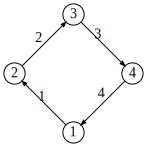

In [4]:
using Catlab.Graphics

to_graphviz(g, prog="circo", node_labels=true, edge_labels=true)

### Example: Petri nets

A version of Petri nets are also C-sets ([Kock 2020](https://arxiv.org/abs/2005.05108)). The schema has four tables:

1. $S$ (states)
2. $T$ (transitions)
3. $I$ (input states to transition)
4. $O$ (output states to transition)

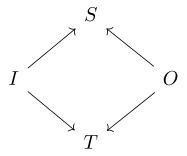

In [5]:
# https://q.uiver.app/?q=WzAsNCxbMSwwLCJTIl0sWzAsMSwiSSJdLFsxLDIsIlQiXSxbMiwxLCJPIl0sWzEsMF0sWzEsMl0sWzMsMl0sWzMsMF1d
TikzCD(raw"""
	& S \\
	I && O \\
	& T
	\arrow[from=2-1, to=1-2]
	\arrow[from=2-1, to=3-2]
	\arrow[from=2-3, to=3-2]
	\arrow[from=2-3, to=1-2]""")

Petri nets based on this schema are provided by our package [AlgebraicPetri.jl](https://github.com/AlgebraicJulia/AlgebraicPetri.jl).

As an example, here is a Petri net for the classic SIR model:

In [6]:
import AlgebraicPetri
using AlgebraicPetri: LabelledPetriNet

sir_petri = LabelledPetriNet((:S, :I, :R),
    :inf => ((:S,:I) => (:I,:I)),
    :rec => (:I => :R))

ACSet with elements T = 1:2, S = 1:3, I = 1:3, O = 1:3
┌───┬───────┐
│ T │ tname │
├───┼───────┤
│ 1 │   inf │
│ 2 │   rec │
└───┴───────┘
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     I │
│ 3 │     R │
└───┴───────┘
┌───┬────┬────┐
│ I │ it │ is │
├───┼────┼────┤
│ 1 │  1 │  1 │
│ 2 │  1 │  2 │
│ 3 │  2 │  2 │
└───┴────┴────┘
┌───┬────┬────┐
│ O │ ot │ os │
├───┼────┼────┤
│ 1 │  1 │  2 │
│ 2 │  1 │  2 │
│ 3 │  2 │  3 │
└───┴────┴────┘

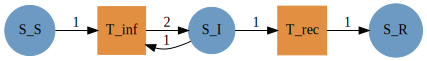

In [7]:
AlgebraicPetri.Graph(sir_petri)

## Structured cospans for open systems

- C-sets can be used to model **systems**, e.g. epidemiology models based on Petri nets
- But then how can we model and compose **open systems**?
- **Structured cospans** provide a mathematical formalism ([Fong 2015](http://www.tac.mta.ca/tac/volumes/30/33/30-33abs.html), [Baez & Courser 2020](http://www.tac.mta.ca/tac/volumes/35/48/35-48abs.html))
- We implemented structured cospans generically in Catlab

### Idea of structured cospans

Ingredients needed for structured cospans:

- A category $X$ containing the systems
- A category $A$, typically "simpler" than $X$, containing the allowable boundaries of systems
- A functor $L: A \to X$ saying how the boundaries are related to the systems

**Example**: For *open graphs*,

- $X = \mathsf{Graph}$ is category of graphs
- $A = \mathsf{Set}$ is category of sets
- $L: \mathsf{Set} \to \mathsf{Graph}$ sends a set $V$ to the graph with vertices $V$ and no edges

**Definition**: A *structured cospan* is a cospan in $X$ of following form, where

- the *apex* $x \in X$ represents the system
- the *feet* $a,b \in A$ represent the "input" and "output" boundaries of the system

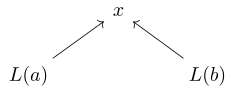

In [8]:
# https://q.uiver.app/?q=WzAsMyxbMSwwLCJ4Il0sWzAsMSwiTChhKSJdLFsyLDEsIkwoYikiXSxbMSwwXSxbMiwwXV0=
TikzCD(raw"""
	& x \\
	{L(a)} && {L(b)}
	\arrow[from=2-1, to=1-2]
	\arrow[from=2-3, to=1-2]""")

Open systems based on structured cospans can be composed along their boundaries to form more complex systems.

### Example: Open graphs

Create open graph with

- inputs = vertex 1
- outputs = vertices 3 and 4

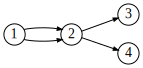

In [9]:
using Catlab.Theories, Catlab.CategoricalAlgebra.FinSets

const OpenGraphOb, OpenGraph = OpenCSetTypes(Graph, :V)

x = Graph()
add_vertices!(x, 4)
add_edges!(x, [1,1,2,2], [2,2,3,4])
f = OpenGraph(x, FinFunction([1],4), FinFunction([3,4],4))

to_graphviz(apex(f), node_labels=true)

Another open graph, where

- inputs = vertices 1 and 2
- ouputs = vertex 4

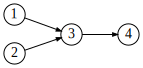

In [10]:
y = Graph()
add_vertices!(y, 4)
add_edges!(y, [1,2,3], [3,3,4])
g = OpenGraph(y, FinFunction([1,2],4), FinFunction([4],4))

to_graphviz(apex(g), node_labels=true)

Composition of open graphs as structured cospans:

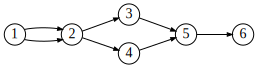

In [11]:
h = compose(f, g)
to_graphviz(apex(h), node_labels=true)

Notice how the two pairs of vertices are glued together, so that the composite graph has $4+4-2 = 6$ vertices.

## Operadic composition of open systems

- When building up complex models, it is often more natural to compose **hierarchically** than sequentially
- To do this, we combine two ingredients:
  1. structured multicospans
  2. operad of undirected wiring diagrams ([Spivak 2013](https://arxiv.org/abs/1305.0297))

(1) **Structured multicospans** are like structured cospans but can have any number of legs, not just two:

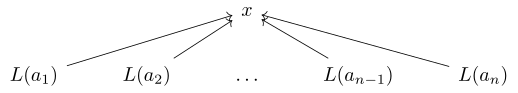

In [12]:
# https://q.uiver.app/?q=WzAsNixbMiwwLCJ4Il0sWzAsMSwiTChhXzEpIl0sWzEsMSwiTChhXzIpIl0sWzIsMSwiXFxkb3RzIl0sWzMsMSwiTChhX3tuLTF9KSJdLFs0LDEsIkwoYV9uKSJdLFsxLDBdLFsyLDBdLFs0LDBdLFs1LDBdXQ==
TikzCD(raw"""
	&& x \\
	{L(a_1)} & {L(a_2)} & \dots & {L(a_{n-1})} & {L(a_n)}
	\arrow[from=2-1, to=1-3]
	\arrow[from=2-2, to=1-3]
	\arrow[from=2-4, to=1-3]
	\arrow[from=2-5, to=1-3]""")

This extra flexibility in partitioning the boundary of the system is often useful.

(2) **Undirected wiring diagrams (UWDs)** are a syntax for hierarchical composition. In mathematical terms, they form an **operad**.

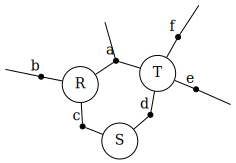

In [13]:
using Catlab.WiringDiagrams, Catlab.Programs

diagram = @relation (a,b,e,f) where (a,b,c,d,e,f) begin
  R(a,b,c)
  S(c,d)
  T(a,d,e,f)
end

to_graphviz(diagram, box_labels=:name, junction_labels=:variable,
    graph_attrs=Dict(:start => "5"))

We will substitute open systems (structured multicospans) into boxes labeled $R, S, T$ to get a larger system.

As a data structure, UWDs are C-sets with four tables:

1. *boxes*: $R$, $S$, $T$
2. *ports* of boxes
3. *outer ports* of diagrams (visualized as dangling wires)
4. *junctions*: $a$, $b$, $c$, $d$, $e$, $f$

In [14]:
diagram

ACSet with elements Box = 1:3, Port = 1:9, OuterPort = 1:4, Junction = 1:6
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    R │
│   2 │    S │
│   3 │    T │
└─────┴──────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   1 │        3 │
│    4 │   2 │        3 │
│    5 │   2 │        4 │
│    6 │   3 │        1 │
│    7 │   3 │        4 │
│    8 │   3 │        5 │
│    9 │   3 │        6 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              5 │
│         4 │              6 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        a │
│        2 │        b │
│        3 │        c │
│        4 │        d │
│        5 │        e │
│        6 │        f │
└──────────┴──────────┘

### Example: Epidemic model with quarantine

We will compositionally construct an epidemic model in which some people will quarantine.

#### Two useful primitives

AlgebraicPetri includes two kinds of primitive Petri nets that occur frequently.

(1) "Exposure"-type transitions, which are open Petri nets with three legs.

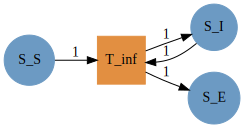

In [15]:
using AlgebraicPetri.Epidemiology: exposure_petri, spontaneous_petri

AlgebraicPetri.Graph(exposure_petri(:S, :I, :E, :inf))

(2) "Spontaneous" transitions, which are open Petri nets with two legs.

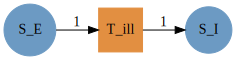

In [16]:
AlgebraicPetri.Graph(spontaneous_petri(:E, :I, :ill))

#### The basic SEIR model

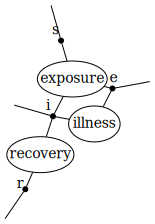

In [17]:
seir_diagram = @relation (s,e,i,r) begin
    exposure(s,i,e) 
    illness(e,i)
    recovery(i,r)
end

to_graphviz(seir_diagram, box_labels=:name, junction_labels=:variable)

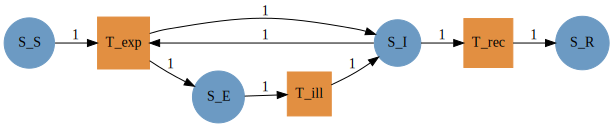

In [18]:
seir_petri = oapply(seir_diagram, Dict(
    :exposure => exposure_petri(:S, :I, :E, :exp),
    :illness => spontaneous_petri(:E, :I, :ill),
    :recovery => spontaneous_petri(:I, :R, :rec)
))

AlgebraicPetri.Graph(seir_petri)

#### Adding quarantine to the model

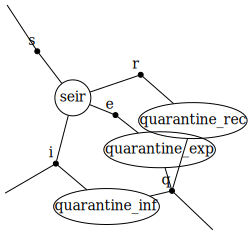

In [19]:
quarantine_diagram = @relation (s,i,q) begin
    seir(s,e,i,r)
    quarantine_exp(e,q)
    quarantine_inf(i,q)
    quarantine_rec(q,r)
end

to_graphviz(quarantine_diagram, box_labels=:name, junction_labels=:variable,
    graph_attrs=Dict(:start => "3"), edge_attrs=Dict(:len => "0.75"))

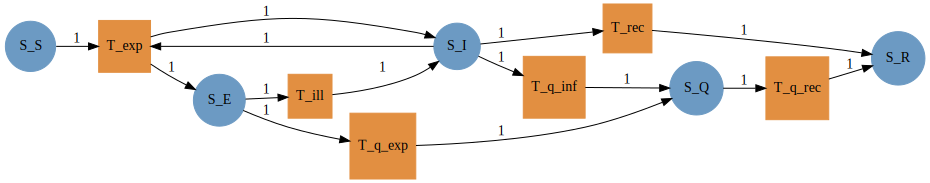

In [20]:
quarantine_petri = oapply(quarantine_diagram, Dict(
    :seir => seir_petri,
    :quarantine_exp => spontaneous_petri(:E, :Q, :q_exp),
    :quarantine_inf => spontaneous_petri(:I, :Q, :q_inf),
    :quarantine_rec => spontaneous_petri(:Q, :R, :q_rec)
))

AlgebraicPetri.Graph(quarantine_petri)

#### Generating code for the model

Finally, we generate Julia code that will compute the vector field for an ODE system based on mass action kinetics.

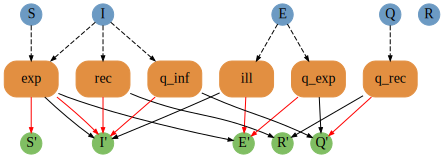

In [21]:
using AlgebraicPetri.BilayerNetworks

quarantine_bn = LabelledBilayerNetwork()
migrate!(quarantine_bn, apex(quarantine_petri))

to_graphviz(quarantine_bn)

In [22]:
BilayerNetworks.compile(quarantine_bn, :du, :ϕ, :u, :params)

:(f!(du, ϕ, u, params, t) = begin
          #= /Users/epatters/.julia/packages/AlgebraicPetri/0pHMr/src/BilayerNetworks.jl:268 =#
          begin
              #= /Users/epatters/.julia/packages/AlgebraicPetri/0pHMr/src/BilayerNetworks.jl:274 =#
              du .= 0.0
              #= /Users/epatters/.julia/packages/AlgebraicPetri/0pHMr/src/BilayerNetworks.jl:275 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[1] *= params[:exp]
              ϕ[2] *= params[:ill]
              ϕ[3] *= params[:rec]
              ϕ[4] *= params[:q_exp]
              ϕ[5] *= params[:q_inf]
              ϕ[6] *= params[:q_rec]
              du[1] -= ϕ[1]
              du[2] -= ϕ[1]
              du[3] -= ϕ[2]
              du[2] -= ϕ[3]
              du[3] -= ϕ[4]
              du[2] -= ϕ[5]
              du[5] -= ϕ[6]
      